### 1. Preliminary Modeling - Predicting NBA VORP

#### 1.1 Load Data

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

os.chdir('C:\\Users\\David\\OneDrive')
from utils.ml_data_proc import tts
from utils.graphs import corrtest,normality_test,regression_results

#read college data
df = pd.read_csv('Projects/nba-draft-player-analysis/data/modeling_data.csv')

#### 1.2 Test Response Variable for Normality

Before beginning any modeling it's import to determine whether the response variable requires any modification. With any statistical modeling, it is assumed that the response variable follows a normal or near-normal distribution. If the response variable does not meet this criteria, then it should be transformed for optimal results

Based on the graphs below along with the results of a Shapiro-Wilks test, it is obvious that this variable has some noise and does not fit a normal distribution. 

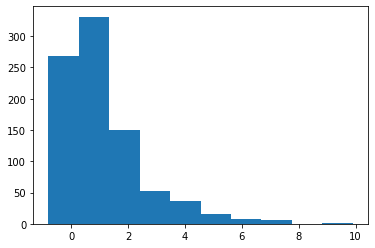

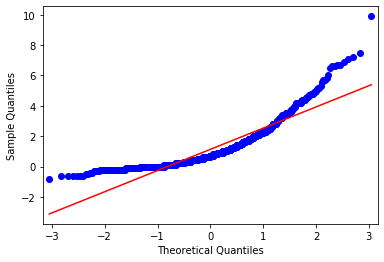

P-value of 0.0 is not greater than .05 and does not meet normality criteria


In [4]:
normality_test(df['nba_vorp'])

##### Using a Yeo-Johnson transformation, it looks like there is an improved shape of the data but it still fails the normality test. The chosen lambda value can be used to transform the values back to the original: value_original = (value_transformed * lmbda + 1) ** (1 / lmbda) - 1

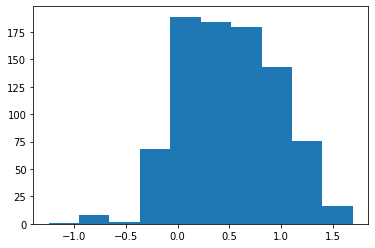

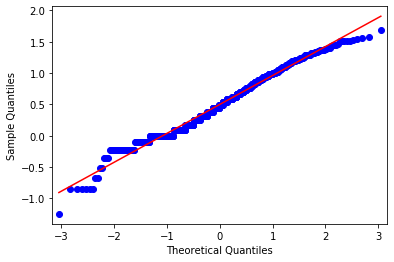

P-value of 0.0 is not greater than .05 and does not meet normality criteria


In [5]:
#Yeo-Johnson Transformation
from scipy import stats

df['nba_vorp_trans'],lmbda = stats.yeojohnson(df['nba_vorp'])
normality_test(df['nba_vorp_trans'])

#### 1.3 Test Independent Variables for Multicollinearity

('offensive_rebounds_per_40', 'total_rebounds_per_40') 0.88
('total_rebounds_per_40', 'height') 0.7


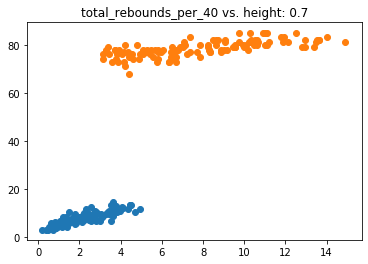

In [7]:
#df['wingspan_ratio'] = df['combine_wingspan']/df['combine_height_w_shoes']

fields = ['minutes_played','assists_per_40', 'blocks_per_40','free_throw_attempts_per_40',
       'offensive_rebounds_per_40', 'personal_fouls_per_40', 'points_per_40',
       'steals_per_40', 'three_point_attempts_per_40','three_point_percentage','free_throw_percentage','field_goal_percentage',
       'total_rebounds_per_40', 'turnovers_per_40','two_point_attempts_per_40','height','yrs_played','nba_vorp_trans']


df_2 = df.dropna(how='any')
corrtest(df_2,fields,.7)

#### 1.4 Process Data for Modeling | Scale, Split into Train and Test

The next step is to transform the data for modeling. For a simple linear regression, the transformation isn't necassary but once more advanced techniques are applied this will be necassary. Therefore it makes sense to simply apply now. The categorical data will go thru a one-hot encoding transformation and the numerical data will be scaled to remove order of magnitude differences in variables

In [8]:
cont_fields = ['minutes_played','assists_per_40', 'blocks_per_40','free_throw_attempts_per_40',
       'offensive_rebounds_per_40', 'personal_fouls_per_40', 'points_per_40',
       'steals_per_40', 'three_point_attempts_per_40','three_point_percentage','free_throw_percentage',
       'total_rebounds_per_40', 'turnovers_per_40','two_point_attempts_per_40','height']

cat_fields = ['yrs_played']

response = 'nba_vorp_trans'


Xtrain,Xtest,ytrain,ytest = tts(df,cat_fields,cont_fields,response)

C:\Users\David\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### 1.5 Linear Regression

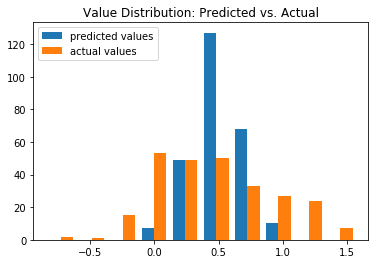

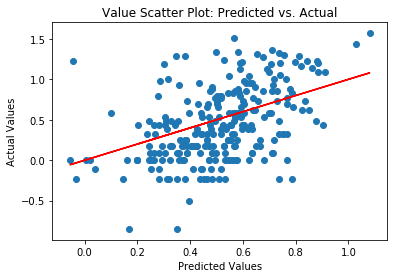

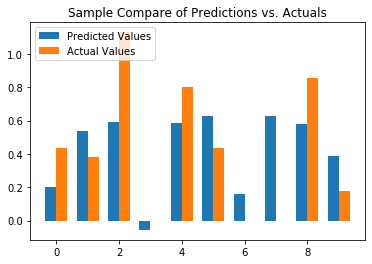

Model Results
-----------------------------------------------
MSE:                 0.161
Explained Variance: 0.233
R^2 Score:          0.219


In [9]:
model1 = LinearRegression()
model1.fit(Xtrain,ytrain)
y_predict = model1.predict(Xtest)
regression_results(y_predict,ytest)

In [10]:
pd.DataFrame({'Feature':Xtrain.columns,'Coefficients':model1.coef_}).sort_values(by='Coefficients',ascending=False).head()

,Feature,Coefficients
0,yrs_played_1,0.182119
11,points_per_40,0.114431
6,assists_per_40,0.089991
16,total_rebounds_per_40,0.087632
12,steals_per_40,0.086392


#### 1.4 Lasso Regression

In [11]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

for alpha in alphas:
    model1 = Lasso(alpha=alpha).fit(Xtrain,ytrain)
    y_predict = model1.predict(Xtrain)
    score = model1.score(Xtrain, ytrain)
    mse = metrics.mean_squared_error(ytrain, y_predict)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}".format(alpha, score, mse))

Alpha:0.0001, R2:0.18, MSE:0.18
Alpha:0.0010, R2:0.18, MSE:0.18
Alpha:0.0100, R2:0.16, MSE:0.18
Alpha:0.1000, R2:0.02, MSE:0.21
Alpha:0.3000, R2:0.00, MSE:0.21
Alpha:0.5000, R2:0.00, MSE:0.21
Alpha:0.7000, R2:0.00, MSE:0.21
Alpha:1.0000, R2:0.00, MSE:0.21


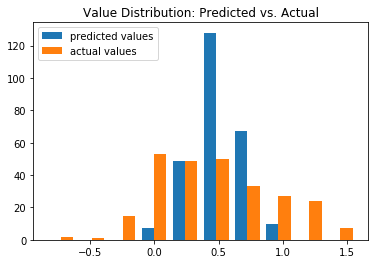

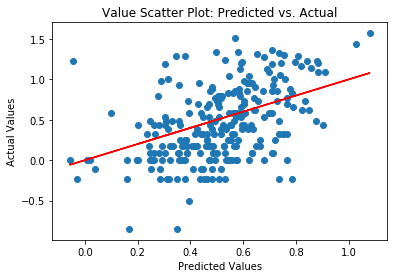

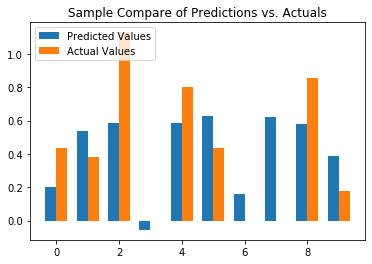

Model Results
-----------------------------------------------
MSE:                 0.161
Explained Variance: 0.233
R^2 Score:          0.218


In [12]:
model2 = Lasso(alpha = .0001)
model2.fit(Xtrain,ytrain)
y_predict = model2.predict(Xtest)
regression_results(y_predict,ytest)

In [13]:
pd.DataFrame({'Feature':Xtrain.columns,'Coefficients':model2.coef_}).sort_values(by='Coefficients',ascending=False).head()

,Feature,Coefficients
0,yrs_played_1,0.229418
11,points_per_40,0.113032
6,assists_per_40,0.089378
16,total_rebounds_per_40,0.087239
12,steals_per_40,0.086482


#### 1.5 SVM Regression

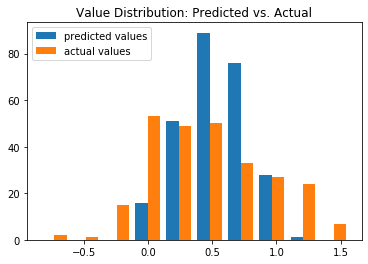

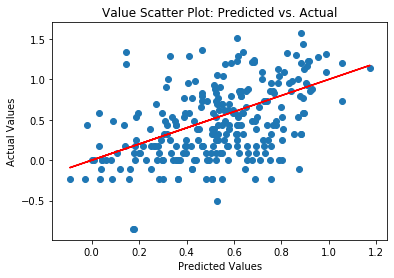

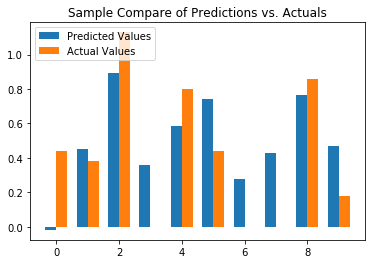

Model Results
-----------------------------------------------
MSE:                 0.163
Explained Variance: 0.233
R^2 Score:          0.21


In [14]:
model3 = SVR(C=1.0, epsilon=0.2,max_iter=-1)
model3.fit(Xtrain,ytrain)
y_predict = model3.predict(Xtest)
regression_results(y_predict,ytest)

#### 1.6 Random Forest Regression

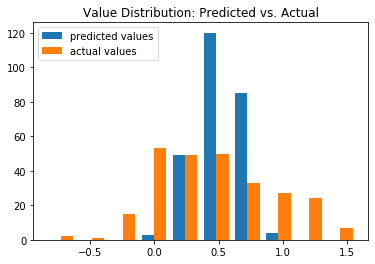

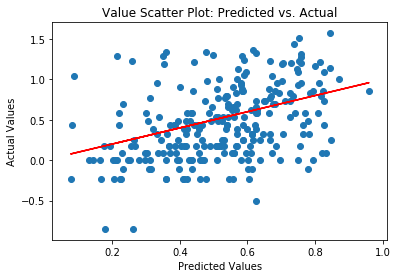

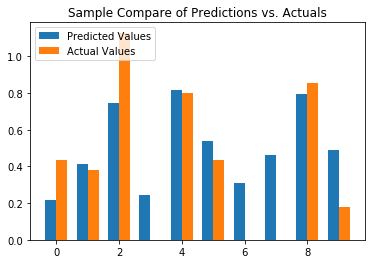

Model Results
-----------------------------------------------
MSE:                 0.173
Explained Variance: 0.181
R^2 Score:          0.16


In [15]:
model4 = RandomForestRegressor()
model4.fit(Xtrain,ytrain)
y_predict = model4.predict(Xtest)
regression_results(y_predict,ytest)

In [19]:
pd.DataFrame({'Feature':Xtrain.columns,'Coefficients':model4.feature_importances_}).sort_values(by='Coefficients',ascending=False).head()

,Feature,Coefficients
12,steals_per_40,0.134576
6,assists_per_40,0.081074
7,blocks_per_40,0.074300
15,free_throw_percentage,0.070993
10,personal_fouls_per_40,0.069963
